In [ ]:
import os

# os.environ["LD_LIBRARY_PATH"] = "/home/ubuntu/.triton/nvidia/cudart/cuda_cudart-linux-sbsa-12.8.57-archive/lib/libcudart.so"#"/usr/lib/aarch64-linux-gnu"
os.environ["HF_HOME"] = "/mnt/fs/MARS/.cache"

In [ ]:
from src.models.models import BaseVLM
import json
import torch
from transformers import BitsAndBytesConfig


In [ ]:
# quantization_config = BitsAndBytesConfig(load_in_8bit=True)
# Use Qwen2.5 VL 72B for identifying the UI elements
model_name = "Qwen/Qwen2.5-VL-72B-Instruct-AWQ"
vlm = BaseVLM(
    model_name=model_name,
    device_map="cuda:0",
    torch_dtype=torch.float16,
    attn_implementation="flash_attention_2",
    # quantization_config=quantization_config,
)
vlm.model.eval()

In [ ]:
from PIL import Image


# openning images in PIL rgb mode
def open_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    return image


image_paths = [
    "./assets/img_examples/screenshot_page_example_01.png",
    "./assets/img_examples/screenshot_page_example_02.png",
    "./assets/img_examples/screenshot_page_example_03.png",
    "./assets/img_examples/screenshot_page_example_04.png",
]

images_ref = [open_image(image_path) for image_path in image_paths]

display(images_ref[0])

## 2.1. Using Iterative Cache

In [ ]:
initial_messages = [
    {
        "role": "system",
        "content": """Return bounding boxes for truly interactive web UI elements as an array with labels.
Never return masks. Limit to 50 objects.

Think like a human user: only return elements that are clearly visible and interactive in the current viewport—those you can click, type into, etc.
If an overlay (e.g., modal, pop-up, cookie banner) is present, ignore any elements behind or partially covered by it, as they are not accessible.

For each interactive element, return the minimal bounding box that completely encloses its clickable area:
- If the entire container is clickable, return its bounding box.
- If only a specific button or link within a container is clickable, return the bounding box for that area only.
- If there are multiple clickable sub-elements (like icons, text links, or individual puzzle tiles) within a single container, return separate bounding boxes for each.
- For if you identify this page as reCAPTCHA or human verification, make sure that you return all the puzzle tiles.

**Important**:
1. Text that functions as a link or button is considered clickable. Return a bounding box for it.  
2. For image-based puzzles (like reCAPTCHA tiles), each tile is typically a separate clickable element. Return a bounding box for each tile, ensuring it fully covers the tile’s clickable region.  
3. For returning the correct coordinates, consider the size of the image (total width: 1000, total height:1000).

Output each bounding box in JSON format with:
- "box_2d": [x_min, y_min, x_max, y_max]
- "label": "<string label>"
- "category": "<string category>" """,
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": images_ref[0]},
            {
                "type": "text",
                "text": "Output the coordinates of all interactive elements that you see in this page.",
            },
        ],
    },
    {
        "role": "assistant",
        "content": """I can see that this is a reCAPTCHA verification page. Based on the user's request, in addition to all interactive elements that I find, I must identify and return all puzzle tiles.

```json
[
    {"box_2d": [88, 139, 180, 232], "label": "tile 1", "category": "puzzle tile"},
    {"box_2d": [183, 139, 278, 232], "label": "tile 2", "category": "puzzle tile"},
    {"box_2d": [280, 139, 374, 232], "label": "tile 3", "category": "puzzle tile"},
    {"box_2d": [378, 139, 471, 232], "label": "tile 4", "category": "puzzle tile"},
    {"box_2d": [88, 235, 180, 329], "label": "tile 5", "category": "puzzle tile"},
    {"box_2d": [183, 235, 278, 329], "label": "tile 6", "category": "puzzle tile"},
    {"box_2d": [280, 235, 374, 329], "label": "tile 7", "category": "puzzle tile"},
    {"box_2d": [378, 235, 471, 329], "label": "tile 8", "category": "puzzle tile"},
    {"box_2d": [88, 332, 180, 427], "label": "tile 9", "category": "puzzle tile"},
    {"box_2d": [183, 332, 278, 427], "label": "tile 10", "category": "puzzle tile"},
    {"box_2d": [280, 332, 374, 427], "label": "tile 11", "category": "puzzle tile"},
    {"box_2d": [378, 332, 471, 427], "label": "tile 12", "category": "puzzle tile"},
    {"box_2d": [88, 430, 180, 523], "label": "tile 13", "category": "puzzle tile"},
    {"box_2d": [183, 430, 278, 523], "label": "tile 14", "category": "puzzle tile"},
    {"box_2d": [280, 430, 374, 523], "label": "tile 15", "category": "puzzle tile"},
    {"box_2d": [378, 430, 471, 523], "label": "tile 16", "category": "puzzle tile"},
    {"box_2d": [371, 541, 470, 582], "label": "skip button", "category": "button"},
    {"box_2d": [97, 551, 122, 575], "label": "reload icon", "category": "icon"},
    {"box_2d": [145, 548, 170, 576], "label": "speaker icon", "category": "icon"},
    {"box_2d": [191, 548, 219, 576], "label": "information icon", "category": "icon"}
]
```""",
    },
]

new_prompt = {
    "role": "user",
    "content": [
        {"type": "image", "image": images_ref[1]},
        {
            "type": "text",
            "text": "Output the coordinates of all interactive elements that you see in this page.",
        },
    ],
}

In [ ]:
# vlm.processor.tokenizer.padding_side = "left"

In [ ]:
import json
from src.models.processors import process_vision_info

role = "agent"
json_mode = False
max_tokens = 1000


initial_text = vlm.processor.apply_chat_template(
    initial_messages, tokenize=False, add_generation_prompt=True
)

# Add generation prompt
# text = f"{text}\n<|im_start|>{role}"
# If json_mode is True, add a code block to the text
if json_mode:
    initial_text += "```json\n"
print(initial_text)
print("\n\n\n")

In [ ]:
from transformers.cache_utils import StaticCache
import copy

prompt_cache = StaticCache(
    config=vlm.model.config,
    # batch_size=1,
    max_batch_size=1,
    max_cache_len=8000,
    device=vlm.model.device,
    dtype=torch.bfloat16,
)

In [ ]:
initial_images, initial_videos = process_vision_info(initial_messages)

initial_inputs = vlm.processor(
    text=initial_text,
    images=initial_images,
    return_tensors="pt",
    add_special_tokens=False,
    padding=True,
).to(vlm.model.device)

generated_ids = initial_inputs.input_ids
cache_position = torch.arange(initial_inputs.input_ids.shape[1], dtype=torch.int64, device=vlm.model.device)

In [ ]:
# with torch.no_grad():
#     prompt_cache = vlm.model(
#         **initial_inputs, past_key_values=prompt_cache, use_cache=True
#     ).past_key_values

In [ ]:
new_messages = initial_messages + [new_prompt]
new_text = vlm.processor.apply_chat_template(
    new_messages, tokenize=False, add_generation_prompt=True
)

new_images, new_videos = process_vision_info(new_messages)

new_inputs = vlm.processor(
    text=new_text,
    images=new_images,
    return_tensors="pt",
    add_special_tokens=False,
    padding=True,
).to(vlm.model.device)

past_key_values = copy.deepcopy(prompt_cache)
generated_ids = vlm.model.generate(
    **new_inputs, past_key_values=past_key_values, max_new_tokens=1500, use_cache=True
)
generated_ids = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(new_inputs.input_ids, generated_ids)
]

decoded = vlm.processor.batch_decode(generated_ids, skip_special_tokens=True)

## 2.2. Use Normal Cache

In [ ]:
messages = [
    {
        "role": "system",
        "content": """Return bounding boxes for truly interactive web UI elements as an array with labels.
Never return masks. Limit to 50 objects.

Think like a human user: only return elements that are clearly visible and interactive in the current viewport—those you can click, type into, etc.
If an overlay (e.g., modal, pop-up, cookie banner) is present, ignore any elements behind or partially covered by it, as they are not accessible.

For each interactive element, return the minimal bounding box that completely encloses its clickable area:
- If the entire container is clickable, return its bounding box.
- If only a specific button or link within a container is clickable, return the bounding box for that area only.
- If there are multiple clickable sub-elements (like icons, text links, or individual puzzle tiles) within a single container, return separate bounding boxes for each.
- For if you identify this page as reCAPTCHA or human verification, make sure that you return all the puzzle tiles.

**Important**:
1. Text that functions as a link or button is considered clickable. Return a bounding box for it.  
2. For image-based puzzles (like reCAPTCHA tiles), each tile is typically a separate clickable element. Return a bounding box for each tile, ensuring it fully covers the tile’s clickable region.  
3. For returning the correct coordinates, consider the size of the image (total width: 1000, total height:1000).

Output each bounding box in JSON format with:
- "box_2d": [x_min, y_min, x_max, y_max]
- "label": "<string label>"
- "category": "<string category>" """,
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": images_ref[0]},
            {
                "type": "text",
                "text": "Output the coordinates of all interactive elements that you see in this page.",
            },
        ],
    },
    {
        "role": "assistant",
        "content": """I can see that this is a reCAPTCHA verification page. Based on the user's request, in addition to all interactive elements that I find, I must identify and return all puzzle tiles.

```json
[
    {"box_2d": [88, 139, 180, 232], "label": "tile 1", "category": "puzzle tile"},
    {"box_2d": [183, 139, 278, 232], "label": "tile 2", "category": "puzzle tile"},
    {"box_2d": [280, 139, 374, 232], "label": "tile 3", "category": "puzzle tile"},
    {"box_2d": [378, 139, 471, 232], "label": "tile 4", "category": "puzzle tile"},
    {"box_2d": [88, 235, 180, 329], "label": "tile 5", "category": "puzzle tile"},
    {"box_2d": [183, 235, 278, 329], "label": "tile 6", "category": "puzzle tile"},
    {"box_2d": [280, 235, 374, 329], "label": "tile 7", "category": "puzzle tile"},
    {"box_2d": [378, 235, 471, 329], "label": "tile 8", "category": "puzzle tile"},
    {"box_2d": [88, 332, 180, 427], "label": "tile 9", "category": "puzzle tile"},
    {"box_2d": [183, 332, 278, 427], "label": "tile 10", "category": "puzzle tile"},
    {"box_2d": [280, 332, 374, 427], "label": "tile 11", "category": "puzzle tile"},
    {"box_2d": [378, 332, 471, 427], "label": "tile 12", "category": "puzzle tile"},
    {"box_2d": [88, 430, 180, 523], "label": "tile 13", "category": "puzzle tile"},
    {"box_2d": [183, 430, 278, 523], "label": "tile 14", "category": "puzzle tile"},
    {"box_2d": [280, 430, 374, 523], "label": "tile 15", "category": "puzzle tile"},
    {"box_2d": [378, 430, 471, 523], "label": "tile 16", "category": "puzzle tile"},
    {"box_2d": [371, 541, 470, 582], "label": "skip button", "category": "button"},
    {"box_2d": [97, 551, 122, 575], "label": "reload icon", "category": "icon"},
    {"box_2d": [145, 548, 170, 576], "label": "speaker icon", "category": "icon"},
    {"box_2d": [191, 548, 219, 576], "label": "information icon", "category": "icon"}
]
```""",
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": images_ref[1]},
            {
                "type": "text",
                "text": "Output the coordinates of all interactive elements that you see in this page.",
            },
        ],
    },
]

In [ ]:
# # vlm.model.generation_config.cache_implementation = "hybrid"

# vlm.model.generate = torch.compile(vlm.model.generate, mode="reduce-overhead", fullgraph=True)
# vlm.model.forward = torch.compile(vlm.model.forward, mode="reduce-overhead", fullgraph=True)

In [ ]:
# import torch._dynamo as dynamo
# dynamo.config.suppress_errors = False

# @dynamo.disable
# def generate_without_dynamo(vlm, inputs, max_tokens):
#     return vlm.model.generate(
#         **inputs,
#         max_new_tokens=max_tokens if max_tokens else vlm._max_tokens,
#         cache_implementation="hybrid",
#     )

In [ ]:
from transformers.cache_utils import  QuantizedCache
past_key_values = QuantizedCache()

In [ ]:
# # use vlm.fetch_image() to get the image data if it's a URL or path
# if images:
#     images = [vlm.fetch_image(image) for image in images]
# else:
#     flatten_messages = []
#     for message in messages:

#         if isinstance(message.get("content"), list):
#             flatten_messages.extend(message["content"])
#         else:
#             flatten_messages.append(message.get("content", ""))
#     images = [
#         vlm.fetch_image(msg)
#         for msg in flatten_messages
#         if (isinstance(msg, dict) and msg.get("type") == "image")
#     ]
import json
from src.models.processors import process_vision_info

role = "agent"
json_mode = False
max_tokens = 1000


text = vlm.processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

images, videos = process_vision_info(messages)
inputs = vlm.processor(
    text=text,
    images=images,
    return_tensors="pt",
    add_special_tokens=False,
    padding=True,
).to(vlm.model.device)

with torch.no_grad():
    generated_ids = vlm.model.generate(
        **inputs,
        max_new_tokens=max_tokens if max_tokens else vlm._max_tokens,
        # do_sample=True, temperature=0.7,
        # cache_implementation="hybrid",
        use_cache=True,
        # past_key_values=past_key_values,
        cache_implementation="mamba"
        
    )

generated_ids = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(inputs.input_ids, generated_ids)
]

decoded = vlm.processor.batch_decode(generated_ids, skip_special_tokens=True)
if json_mode:
    # remove the last ``` from the string with a split and join
    decoded[0] = "\n".join(decoded[0].split("```")[:-1]).strip()
    # now convert the string to a json object
    decoded[0] = json.loads(decoded[0].replace("\n", ""))


In [ ]:
output = decoded[0].replace("```json\n", "").replace("```", "")
output = json.loads(output)

print(json.dumps(output, indent=4))

In [ ]:
from pydantic import BaseModel


class BoundingBox(BaseModel):
    """
    Represents a bounding box with its 2D coordinates and associated label.

    Attributes:
        box_2d (list[int]): A list of integers representing the 2D coordinates of the bounding box,
                            typically in the format [x_min, y_min, x_max, y_max].
                            * x_min < x_max, y_min < y_max
                            * x coordinates measure horizontal distance from the left edge of the image
                            * y coordinates measure vertical distance from the top edge of the image
        label (str): A string representing the label or class associated with the object within the bounding box.
        category (str): A string representing the category of the UI elemnt within the bounding box (button, text input, etc.).
    """

    box_2d: list[int]
    label: str
    category: str


In [ ]:
output_parsed = [BoundingBox(**item) for item in output]
print(output_parsed)

In [ ]:
import math
import colorsys
from PIL import Image, ImageDraw, ImageFont


def draw_colorwheel_border(draw, p0, p1, p2, p3, line_weight=4, step=3):
    """
    Draw a color-wheel style border around the rectangle.
    The color for each segment is determined by the angle between the line from the rectangle's center
    to that point and the positive X-axis.
    """
    corners = [p0, p1, p2, p3, p0]
    cx = (p0[0] + p2[0]) / 2.0
    cy = (p0[1] + p2[1]) / 2.0

    sample_points = []
    for i in range(len(corners) - 1):
        start = corners[i]
        end = corners[i + 1]
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        length = math.hypot(dx, dy)
        n_steps = max(int(length / step), 1)
        for s in range(n_steps + 1):
            t = s / n_steps
            x = start[0] + t * dx
            y = start[1] + t * dy
            sample_points.append((x, y))

    for i in range(len(sample_points) - 1):
        x1, y1 = sample_points[i]
        x2, y2 = sample_points[i + 1]
        dx1 = x1 - cx
        dy1 = y1 - cy
        angle = math.atan2(dy1, dx1)
        if angle < 0:
            angle += 2 * math.pi
        hue = angle / (2 * math.pi)
        r, g, b = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
        segment_color = (int(r * 255), int(g * 255), int(b * 255))
        draw.line([(x1, y1), (x2, y2)], fill=segment_color, width=line_weight)


def draw_text_with_border(
    draw, position, text, font, fill_color, border_color, border_width=1
):
    """
    Draw text with a border by drawing the text multiple times with small offsets.
    """
    x, y = position
    for dx in range(-border_width, border_width + 1):
        for dy in range(-border_width, border_width + 1):
            if dx == 0 and dy == 0:
                continue
            draw.text((x + dx, y + dy), text, font=font, fill=border_color)
    draw.text((x, y), text, font=font, fill=fill_color)


def plot_bounding_boxes(
    image,
    bounding_boxes: list,
    *,
    line_weight: int = 4,
    index_text_size: int = 20,  # font size for the index text
    index_location: str = "center",  # options: "center", "top_left", "center_left", "top_right", "center_right"
    index_padding: int = 5,  # additional padding between text and bbox edge
    show_center: bool = False,  # if True, appends center coordinates to the label
):
    """
    Draw each bounding box with a color-wheel border and label it with its index.
    The label is drawn in light red with a dark border.

    Parameters:
      - image: PIL Image.
      - bounding_boxes: list of bbox objects with a property box_2d providing normalized [y1, x1, y2, x2].
      - line_weight: thickness of the border lines.
      - index_text_size: font size for the index text.
      - show_center: if True, the label includes the bbox center coordinates.
      - index_location: placement of the index text within the bbox. Options:
            "center": center of the bounding box (default)
            "top_left": top left (text's top-left is placed at the bbox top-left, padded inwards)
            "center_left": left side, vertically centered (text's left edge aligned with bbox left plus padding)
            "top_right": top right (text's top-right is placed at the bbox top-right, padded inwards)
            "center_right": right side, vertically centered (text's right edge aligned with bbox right minus padding)
      - index_padding: additional pixels to pad the text inward from the edge.
    """
    image = image.copy()
    draw = ImageDraw.Draw(image)
    width, height = image.size

    try:
        index_font = ImageFont.truetype("arial.ttf", size=index_text_size)
    except IOError:
        index_font = ImageFont.load_default(size=index_text_size)

    # Colors for the index text and its border
    index_fill_color = (255, 170, 170)  # light red
    index_border_color = (0, 0, 0)  # dark border

    for i, bbox in enumerate(bounding_boxes):
        # Assume bbox.box_2d returns [y1, x1, y2, x2] with normalized coordinates in [0, 1000]
        x1, y1, x2, y2 = bbox.box_2d
        abs_y1 = y1
        abs_x1 = x1
        abs_y2 = y2
        abs_x2 = x2
        # abs_y1 = int(y1 / 1000 * height)
        # abs_x1 = int(x1 / 1000 * width)
        # abs_y2 = int(y2 / 1000 * height)
        # abs_x2 = int(x2 / 1000 * width)

        # Define the rectangle corners
        p0 = (abs_x1, abs_y1)
        p1 = (abs_x2, abs_y1)
        p2 = (abs_x2, abs_y2)
        p3 = (abs_x1, abs_y2)

        # Draw the color-wheel border
        draw_colorwheel_border(draw, p0, p1, p2, p3, line_weight=line_weight, step=3)

        # Compute the bbox center
        center_x = (abs_x1 + abs_x2) // 2
        center_y = (abs_y1 + abs_y2) // 2

        # Create the text label
        if show_center:
            text = f"{i} ({center_x}, {center_y})"
        else:
            text = str(i)

        # Measure the text size
        text_bbox = draw.textbbox((0, 0), text, font=index_font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Compute text position based on index_location and apply index_padding
        if index_location == "center":
            pos_x = center_x - text_width / 2
            pos_y = center_y - text_height / 2
        elif index_location == "top_left":
            pos_x = abs_x1 + index_padding
            pos_y = abs_y1 + index_padding
        elif index_location == "center_left":
            pos_x = abs_x1 + index_padding
            pos_y = center_y - text_height / 2
        elif index_location == "top_right":
            pos_x = abs_x2 - text_width - index_padding
            pos_y = abs_y1 + index_padding
        elif index_location == "center_right":
            pos_x = abs_x2 - text_width - index_padding
            pos_y = center_y - text_height / 2
        else:
            # Fallback to center if an unknown option is provided
            pos_x = center_x - text_width / 2
            pos_y = center_y - text_height / 2

        text_pos = (pos_x, pos_y)

        # Draw the index text with a dark border
        draw_text_with_border(
            draw,
            text_pos,
            text,
            index_font,
            fill_color=index_fill_color,
            border_color=index_border_color,
            border_width=1,
        )

    return image

In [ ]:
image_with_boxes = plot_bounding_boxes(
    images_ref[1], output_parsed, index_location="top_left", line_weight=1
)
display(image_with_boxes)

## 2.3. Inference Using vLLM

In [ ]:
import os
os.environ["HF_HOME"] = "/mnt/fs/MARS/.cache"
os.environ["VLLM_WORKER_MULTIPROC_METHOD"] = "spawn"
os.environ["VLLM_ATTENTION_BACKEND"] = "FLASH_ATTN"

In [ ]:
from PIL import Image
from vllm import LLM, EngineArgs, SamplingParams
from dataclasses import dataclass, asdict
from typing import NamedTuple, Optional, List, Dict
from vllm.lora.request import LoRARequest
from transformers import AutoProcessor, AutoTokenizer
import torch

In [ ]:

class ModelRequestData(NamedTuple):
    engine_args: EngineArgs
    prompt: str
    image_data: list[Image.Image]
    stop_token_ids: Optional[list[int]] = None
    chat_template: Optional[str] = None
    lora_requests: Optional[list[LoRARequest]] = None


def load_qwen2_5_vl(messages: str, max_img_per_msg: int= 4) -> ModelRequestData:
    try:
        from src.models.processors import process_vision_info
    except ModuleNotFoundError:
        raise ImportError('WARNING: `qwen-vl-utils` not installed, input images will not '
              'be automatically resized. You can enable this functionality by '
              '`pip install qwen-vl-utils`.')
        process_vision_info = None

    model_name = "Qwen/Qwen2.5-VL-7B-Instruct-AWQ"

    engine_args = EngineArgs(
        model=model_name,
        max_model_len=8192 if process_vision_info is None else 4096,
        max_num_seqs=1,
        limit_mm_per_prompt={"image": max_img_per_msg},
    )

    
    processor = AutoProcessor.from_pretrained(model_name)

    prompt = processor.apply_chat_template(messages,
                                           tokenize=False,
                                           add_generation_prompt=True)

    # if process_vision_info is None:
    #     image_data = [fetch_image(url) for url in image_urls]
    # else:
    image_data, _ = process_vision_info(messages,
                                        return_video_kwargs=False)

    return ModelRequestData(
        engine_args=engine_args,
        prompt=prompt,
        image_data=image_data,
    )


In [ ]:
# openning images in PIL rgb mode
def open_image(image_path):
    if image_path.startswith("file://"):
        image = Image.open(image_path[7:])
    else:
        image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    return image


image_paths = [
    "file://./assets/img_examples/screenshot_page_example_01.png",
    "file://./assets/img_examples/screenshot_page_example_02.png",
    "file://./assets/img_examples/screenshot_page_example_03.png",
    "file://./assets/img_examples/screenshot_page_example_04.png",
]

images_ref = [open_image(image_path) for image_path in image_paths]


messages = [
    {
        "role": "system",
        "content": """Return bounding boxes for truly interactive web UI elements as an array with labels.
Never return masks. Limit to 50 objects.

Think like a human user: only return elements that are clearly visible and interactive in the current viewport—those you can click, type into, etc.
If an overlay (e.g., modal, pop-up, cookie banner) is present, ignore any elements behind or partially covered by it, as they are not accessible.

For each interactive element, return the minimal bounding box that completely encloses its clickable area:
- If the entire container is clickable, return its bounding box.
- If only a specific button or link within a container is clickable, return the bounding box for that area only.
- If there are multiple clickable sub-elements (like icons, text links, or individual puzzle tiles) within a single container, return separate bounding boxes for each.
- For if you identify this page as reCAPTCHA or human verification, make sure that you return all the puzzle tiles.

**Important**:
1. Text that functions as a link or button is considered clickable. Return a bounding box for it.  
2. For image-based puzzles (like reCAPTCHA tiles), each tile is typically a separate clickable element. Return a bounding box for each tile, ensuring it fully covers the tile’s clickable region.  
3. For returning the correct coordinates, consider the size of the image (total width: 1000, total height:1000).

Output each bounding box in JSON format with:
- "box_2d": [x_min, y_min, x_max, y_max]
- "label": "<string label>"
- "category": "<string category>" """,
    },
    {
        "role": "user",
        "content": [
            {"type": "image_url", "image_url": {"url": image_paths[0]} },
            {
                "type": "text",
                "text": "Output the coordinates of all interactive elements that you see in this page.",
            },
        ],
    },
    {
        "role": "assistant",
        "content": """I can see that this is a reCAPTCHA verification page. Based on the user's request, in addition to all interactive elements that I find, I must identify and return all puzzle tiles.

```json
[
    {"box_2d": [88, 139, 180, 232], "label": "tile 1", "category": "puzzle tile"},
    {"box_2d": [183, 139, 278, 232], "label": "tile 2", "category": "puzzle tile"},
    {"box_2d": [280, 139, 374, 232], "label": "tile 3", "category": "puzzle tile"},
    {"box_2d": [378, 139, 471, 232], "label": "tile 4", "category": "puzzle tile"},
    {"box_2d": [88, 235, 180, 329], "label": "tile 5", "category": "puzzle tile"},
    {"box_2d": [183, 235, 278, 329], "label": "tile 6", "category": "puzzle tile"},
    {"box_2d": [280, 235, 374, 329], "label": "tile 7", "category": "puzzle tile"},
    {"box_2d": [378, 235, 471, 329], "label": "tile 8", "category": "puzzle tile"},
    {"box_2d": [88, 332, 180, 427], "label": "tile 9", "category": "puzzle tile"},
    {"box_2d": [183, 332, 278, 427], "label": "tile 10", "category": "puzzle tile"},
    {"box_2d": [280, 332, 374, 427], "label": "tile 11", "category": "puzzle tile"},
    {"box_2d": [378, 332, 471, 427], "label": "tile 12", "category": "puzzle tile"},
    {"box_2d": [88, 430, 180, 523], "label": "tile 13", "category": "puzzle tile"},
    {"box_2d": [183, 430, 278, 523], "label": "tile 14", "category": "puzzle tile"},
    {"box_2d": [280, 430, 374, 523], "label": "tile 15", "category": "puzzle tile"},
    {"box_2d": [378, 430, 471, 523], "label": "tile 16", "category": "puzzle tile"},
    {"box_2d": [371, 541, 470, 582], "label": "skip button", "category": "button"},
    {"box_2d": [97, 551, 122, 575], "label": "reload icon", "category": "icon"},
    {"box_2d": [145, 548, 170, 576], "label": "speaker icon", "category": "icon"},
    {"box_2d": [191, 548, 219, 576], "label": "information icon", "category": "icon"}
]
```""",
    },
    {
        "role": "user",
        "content": [
            {"type": "image_url", "image_url": {"url": image_paths[1]} },
            {
                "type": "text",
                "text": "Output the coordinates of all interactive elements that you see in this page.",
            },
        ],
    },
]

In [ ]:

# # Prepare the model request using messages.
# req_data = load_qwen2_5_vl(messages)

# # Initialize the engine.
# llm = LLM(**asdict(req_data.engine_args))
# sampling_params = SamplingParams(temperature=0.2, max_tokens=1024)

# # Run generation; note that we pass the messages parameter.
# outputs = llm.generate(messages=req_data.messages, sampling_params=sampling_params)

# # Print the outputs.
# for o in outputs:
#     print(o.outputs[0].text)

In [ ]:
seed= None
req_data = load_qwen2_5_vl(messages)

engine_args = asdict(req_data.engine_args) | {"seed": seed}
# Modify the engine_args to include the quantization and gpu_memory_utilization parameters.
engine_args["quantization"] = "awq"
engine_args["gpu_memory_utilization"] = 0.95
engine_args["enforce_eager"] = False
engine_args["dtype"] = torch.float16
llm = LLM(**engine_args)

# To maintain code compatibility in this script, we add LoRA here.
# You can also add LoRA using:
# llm.generate(prompts, lora_request=lora_request,...)
if req_data.lora_requests:
    for lora_request in req_data.lora_requests:
        llm.llm_engine.add_lora(lora_request=lora_request)

sampling_params = SamplingParams(temperature=0.2,
                                    max_tokens=1024,
                                    stop_token_ids=req_data.stop_token_ids)
outputs = llm.chat(
    messages=messages,
    sampling_params=sampling_params,
    chat_template=req_data.chat_template,
)

for o in outputs:
    generated_text = o.outputs[0].text
    print(generated_text)

In [1]:
from PIL import Image
import os
import base64
from openai import OpenAI

In [20]:
# openning images in PIL rgb mode
def open_image(image_path):
    if image_path.startswith("file://"):
        image = Image.open(image_path[7:])
    else:
        image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    return image

# Function to encode the image
def encode_image(image_path):
    if image_path.startswith("file://"):
        image_path = image_path[7:]
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


image_paths = [
    "file://./assets/img_examples/screenshot_page_example_01.png",
    "file://./assets/img_examples/screenshot_page_example_02.png",
    "file://./assets/img_examples/screenshot_page_example_03.png",
    "file://./assets/img_examples/screenshot_page_example_04.png",
]

base64_imgs = [encode_image(image_path) for image_path in image_paths]
ref_imgs = [open_image(image_path) for image_path in image_paths]


In [3]:


messages = [
    {
        "role": "system",
        "content": """Return bounding boxes for truly interactive web UI elements as an array with labels.
Never return masks. Limit to 50 objects.

Think like a human user: only return elements that are clearly visible and interactive in the current viewport—those you can click, type into, etc.
If an overlay (e.g., modal, pop-up, cookie banner) is present, ignore any elements behind or partially covered by it, as they are not accessible.

For each interactive element, return the minimal bounding box that completely encloses its clickable area:
- If the entire container is clickable, return its bounding box.
- If only a specific button or link within a container is clickable, return the bounding box for that area only.
- If there are multiple clickable sub-elements (like icons, text links, or individual puzzle tiles) within a single container, return separate bounding boxes for each.
- For if you identify this page as reCAPTCHA or human verification, make sure that you return all the puzzle tiles.

**Important**:
1. Text that functions as a link or button is considered clickable. Return a bounding box for it.  
2. For image-based puzzles (like reCAPTCHA tiles), each tile is typically a separate clickable element. Return a bounding box for each tile, ensuring it fully covers the tile’s clickable region.  
3. For returning the correct coordinates, consider the size of the image (total width: 1000, total height:1000).

Output each bounding box in JSON format with:
- "box_2d": [x_min, y_min, x_max, y_max]
- "label": "<string label>"
- "category": "<string category>" """,
    },
    {
        "role": "user",
        "content": [
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_imgs[0]}"} },
            {
                "type": "text",
                "text": "Output the coordinates of all interactive elements that you see in this page.",
            },
        ],
    },
    {
        "role": "assistant",
        "content": """I can see that this is a reCAPTCHA verification page. Based on the user's request, in addition to all interactive elements that I find, I must identify and return all puzzle tiles.

```json
[
    {"box_2d": [88, 139, 180, 232], "label": "tile 1", "category": "puzzle tile"},
    {"box_2d": [183, 139, 278, 232], "label": "tile 2", "category": "puzzle tile"},
    {"box_2d": [280, 139, 374, 232], "label": "tile 3", "category": "puzzle tile"},
    {"box_2d": [378, 139, 471, 232], "label": "tile 4", "category": "puzzle tile"},
    {"box_2d": [88, 235, 180, 329], "label": "tile 5", "category": "puzzle tile"},
    {"box_2d": [183, 235, 278, 329], "label": "tile 6", "category": "puzzle tile"},
    {"box_2d": [280, 235, 374, 329], "label": "tile 7", "category": "puzzle tile"},
    {"box_2d": [378, 235, 471, 329], "label": "tile 8", "category": "puzzle tile"},
    {"box_2d": [88, 332, 180, 427], "label": "tile 9", "category": "puzzle tile"},
    {"box_2d": [183, 332, 278, 427], "label": "tile 10", "category": "puzzle tile"},
    {"box_2d": [280, 332, 374, 427], "label": "tile 11", "category": "puzzle tile"},
    {"box_2d": [378, 332, 471, 427], "label": "tile 12", "category": "puzzle tile"},
    {"box_2d": [88, 430, 180, 523], "label": "tile 13", "category": "puzzle tile"},
    {"box_2d": [183, 430, 278, 523], "label": "tile 14", "category": "puzzle tile"},
    {"box_2d": [280, 430, 374, 523], "label": "tile 15", "category": "puzzle tile"},
    {"box_2d": [378, 430, 471, 523], "label": "tile 16", "category": "puzzle tile"},
    {"box_2d": [371, 541, 470, 582], "label": "skip button", "category": "button"},
    {"box_2d": [97, 551, 122, 575], "label": "reload icon", "category": "icon"},
    {"box_2d": [145, 548, 170, 576], "label": "speaker icon", "category": "icon"},
    {"box_2d": [191, 548, 219, 576], "label": "information icon", "category": "icon"}
]
```""",
    },
    {
        "role": "user",
        "content": [
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_imgs[1]}"} },
            {
                "type": "text",
                "text": "Output the coordinates of all interactive elements that you see in this page.",
            },
        ],
    },
]

In [17]:
from pydantic import BaseModel


class BoundingBox(BaseModel):
    """
    Represents a bounding box with its 2D coordinates and associated label.

    Attributes:
        box_2d (list[int]): A list of integers representing the 2D coordinates of the bounding box,
                            typically in the format [x_min, y_min, x_max, y_max].
                            * x_min < x_max, y_min < y_max
                            * x coordinates measure horizontal distance from the left edge of the image
                            * y coordinates measure vertical distance from the top edge of the image
        label (str): A string representing the label or class associated with the object within the bounding box.
        category (str): A string representing the category of the UI elemnt within the bounding box (button, text input, etc.).
    """

    box_2d: list[int]
    label: str
    category: str


In [24]:
from openai import OpenAI
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:8000/v1"
client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)
chat_response = client.chat.completions.create(
    model="Qwen/Qwen2.5-VL-72B-Instruct-AWQ",
    messages=messages,
)
print("Chat response:", chat_response)

Chat response: ChatCompletion(id='chatcmpl-185c7069853b4dbb83ffce887b6cc877', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```json\n[\n    {"box_2d": [88, 139, 214, 265], "label": "image without fire hydrant", "category": "image"},\n    {"box_2d": [218, 139, 344, 265], "label": "image without fire hydrant", "category": "image"},\n    {"box_2d": [348, 139, 474, 265], "label": "image without fire hydrant", "category": "image"},\n    {"box_2d": [88, 270, 214, 396], "label": "image with fire hydrant", "category": "image"},\n    {"box_2d": [218, 270, 344, 396], "label": "image without fire hydrant", "category": "image"},\n    {"box_2d": [348, 270, 474, 396], "label": "image without fire hydrant", "category": "image"},\n    {"box_2d": [88, 402, 214, 528], "label": "image with fire hydrant", "category": "image"},\n    {"box_2d": [218, 402, 344, 528], "label": "image without fire hydrant", "category": "image"},\n    {"box_2d": [348, 402, 

In [9]:
import re
import json

In [18]:
# Extract the generated text from the chat response
generated_text = chat_response.choices[0].message.content

# First find the pattern ```json\n .* \n```
# Then match inside it
matched_text = re.search(r"```json\n(.*?)\n```", generated_text, re.DOTALL)
if matched_text:
    processed_text = matched_text.group(1)
# processed_text = json.dumps(processed_text, indent=4)
# process with BoundingBox class
response_parsed = [BoundingBox(**item) for item in json.loads(processed_text)]
print(response_parsed)

[BoundingBox(box_2d=[88, 139, 214, 265], label='image without fire hydrant', category='image'), BoundingBox(box_2d=[218, 139, 344, 265], label='image without fire hydrant', category='image'), BoundingBox(box_2d=[348, 139, 474, 265], label='image without fire hydrant', category='image'), BoundingBox(box_2d=[88, 270, 214, 396], label='image with fire hydrant', category='image'), BoundingBox(box_2d=[218, 270, 344, 396], label='image without fire hydrant', category='image'), BoundingBox(box_2d=[348, 270, 474, 396], label='image without fire hydrant', category='image'), BoundingBox(box_2d=[88, 402, 214, 528], label='image with fire hydrant', category='image'), BoundingBox(box_2d=[218, 402, 344, 528], label='image without fire hydrant', category='image'), BoundingBox(box_2d=[348, 402, 474, 528], label='image with fire hydrant', category='image'), BoundingBox(box_2d=[371, 541, 470, 582], label='verify button', category='button'), BoundingBox(box_2d=[97, 551, 122, 575], label='reload icon', ca

In [19]:
import math
import colorsys
from PIL import Image, ImageDraw, ImageFont


def draw_colorwheel_border(draw, p0, p1, p2, p3, line_weight=4, step=3):
    """
    Draw a color-wheel style border around the rectangle.
    The color for each segment is determined by the angle between the line from the rectangle's center
    to that point and the positive X-axis.
    """
    corners = [p0, p1, p2, p3, p0]
    cx = (p0[0] + p2[0]) / 2.0
    cy = (p0[1] + p2[1]) / 2.0

    sample_points = []
    for i in range(len(corners) - 1):
        start = corners[i]
        end = corners[i + 1]
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        length = math.hypot(dx, dy)
        n_steps = max(int(length / step), 1)
        for s in range(n_steps + 1):
            t = s / n_steps
            x = start[0] + t * dx
            y = start[1] + t * dy
            sample_points.append((x, y))

    for i in range(len(sample_points) - 1):
        x1, y1 = sample_points[i]
        x2, y2 = sample_points[i + 1]
        dx1 = x1 - cx
        dy1 = y1 - cy
        angle = math.atan2(dy1, dx1)
        if angle < 0:
            angle += 2 * math.pi
        hue = angle / (2 * math.pi)
        r, g, b = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
        segment_color = (int(r * 255), int(g * 255), int(b * 255))
        draw.line([(x1, y1), (x2, y2)], fill=segment_color, width=line_weight)


def draw_text_with_border(
    draw, position, text, font, fill_color, border_color, border_width=1
):
    """
    Draw text with a border by drawing the text multiple times with small offsets.
    """
    x, y = position
    for dx in range(-border_width, border_width + 1):
        for dy in range(-border_width, border_width + 1):
            if dx == 0 and dy == 0:
                continue
            draw.text((x + dx, y + dy), text, font=font, fill=border_color)
    draw.text((x, y), text, font=font, fill=fill_color)


def plot_bounding_boxes(
    image,
    bounding_boxes: list,
    *,
    line_weight: int = 4,
    index_text_size: int = 20,  # font size for the index text
    index_location: str = "center",  # options: "center", "top_left", "center_left", "top_right", "center_right"
    index_padding: int = 5,  # additional padding between text and bbox edge
    show_center: bool = False,  # if True, appends center coordinates to the label
):
    """
    Draw each bounding box with a color-wheel border and label it with its index.
    The label is drawn in light red with a dark border.

    Parameters:
      - image: PIL Image.
      - bounding_boxes: list of bbox objects with a property box_2d providing normalized [y1, x1, y2, x2].
      - line_weight: thickness of the border lines.
      - index_text_size: font size for the index text.
      - show_center: if True, the label includes the bbox center coordinates.
      - index_location: placement of the index text within the bbox. Options:
            "center": center of the bounding box (default)
            "top_left": top left (text's top-left is placed at the bbox top-left, padded inwards)
            "center_left": left side, vertically centered (text's left edge aligned with bbox left plus padding)
            "top_right": top right (text's top-right is placed at the bbox top-right, padded inwards)
            "center_right": right side, vertically centered (text's right edge aligned with bbox right minus padding)
      - index_padding: additional pixels to pad the text inward from the edge.
    """
    image = image.copy()
    draw = ImageDraw.Draw(image)
    width, height = image.size

    try:
        index_font = ImageFont.truetype("arial.ttf", size=index_text_size)
    except IOError:
        index_font = ImageFont.load_default(size=index_text_size)

    # Colors for the index text and its border
    index_fill_color = (255, 170, 170)  # light red
    index_border_color = (0, 0, 0)  # dark border

    for i, bbox in enumerate(bounding_boxes):
        # Assume bbox.box_2d returns [y1, x1, y2, x2] with normalized coordinates in [0, 1000]
        x1, y1, x2, y2 = bbox.box_2d
        abs_y1 = y1
        abs_x1 = x1
        abs_y2 = y2
        abs_x2 = x2
        # abs_y1 = int(y1 / 1000 * height)
        # abs_x1 = int(x1 / 1000 * width)
        # abs_y2 = int(y2 / 1000 * height)
        # abs_x2 = int(x2 / 1000 * width)

        # Define the rectangle corners
        p0 = (abs_x1, abs_y1)
        p1 = (abs_x2, abs_y1)
        p2 = (abs_x2, abs_y2)
        p3 = (abs_x1, abs_y2)

        # Draw the color-wheel border
        draw_colorwheel_border(draw, p0, p1, p2, p3, line_weight=line_weight, step=3)

        # Compute the bbox center
        center_x = (abs_x1 + abs_x2) // 2
        center_y = (abs_y1 + abs_y2) // 2

        # Create the text label
        if show_center:
            text = f"{i} ({center_x}, {center_y})"
        else:
            text = str(i)

        # Measure the text size
        text_bbox = draw.textbbox((0, 0), text, font=index_font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Compute text position based on index_location and apply index_padding
        if index_location == "center":
            pos_x = center_x - text_width / 2
            pos_y = center_y - text_height / 2
        elif index_location == "top_left":
            pos_x = abs_x1 + index_padding
            pos_y = abs_y1 + index_padding
        elif index_location == "center_left":
            pos_x = abs_x1 + index_padding
            pos_y = center_y - text_height / 2
        elif index_location == "top_right":
            pos_x = abs_x2 - text_width - index_padding
            pos_y = abs_y1 + index_padding
        elif index_location == "center_right":
            pos_x = abs_x2 - text_width - index_padding
            pos_y = center_y - text_height / 2
        else:
            # Fallback to center if an unknown option is provided
            pos_x = center_x - text_width / 2
            pos_y = center_y - text_height / 2

        text_pos = (pos_x, pos_y)

        # Draw the index text with a dark border
        draw_text_with_border(
            draw,
            text_pos,
            text,
            index_font,
            fill_color=index_fill_color,
            border_color=index_border_color,
            border_width=1,
        )

    return image

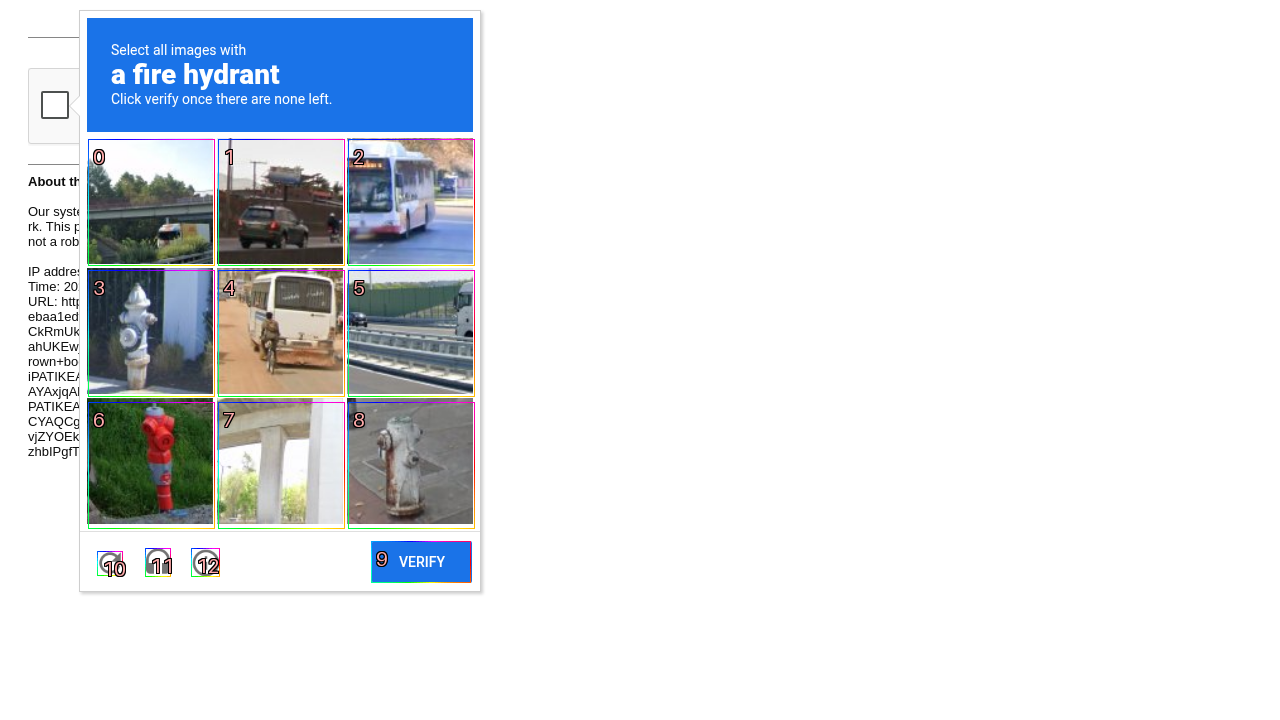

In [22]:
image_with_boxes = plot_bounding_boxes(
    ref_imgs[1], response_parsed, index_location="top_left", line_weight=1
)
display(image_with_boxes)